# FOMO - Faster Objects, More Objects

## Imports

In [203]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from io import TextIOBase

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchmetrics import MetricCollection, MeanAbsoluteError, MeanSquaredError
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision, BinaryRecall

import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from monai.losses.dice import DiceLoss

## Dataset

#### Dataset parameters

In [204]:
# path to directory with dataset
DATASET_DIR = Path("../Datasets/CARPK")

# set true if test subset exists in dataset, otherwise uses validation set for testing
TEST_DATASET = False

# define classes labels and corresponding indexes
CLASSES = {
    "car": 0
}

#### Convert bounding boxes labels to centroid masks

In [205]:
class BoundingBoxToMask:
    def __init__(self, image_resolution: int, grid_scale: int, number_of_classes: int):
        self._image_resolution = image_resolution
        self._grid_scale = grid_scale
        self._number_of_classes = number_of_classes

    def __call__(self, label: TextIOBase) -> (torch.Tensor, list[int]):
        """
        Convert YOLO bounding boxes stored in .txt files to FOMO centroids. Used in label processing.
        @label: .txt filename with bounding boxes
        @returns:
            - mask: binary tensor with centroids marked with ones and background marked with zeroes
            - count: list number of objects in the mask for each class
        """
        grid_resolution = int(self._image_resolution / self._grid_scale)
        masks = []
        count = []
        for i in range(self._number_of_classes):
            class_mask = torch.zeros((grid_resolution, grid_resolution), dtype=float)
            bounding_boxes = label.readlines()
            for bounding_box in bounding_boxes:  
                # get bounding box class and position 
                [c, x, y, _, _] = [                 
                    float(coords) for coords in bounding_box.split()
                ]  
                if c == i:
                    # calculate corresponiding coordinates on output mask
                    x = int(x * grid_resolution)    
                    y = int(y * grid_resolution)
                    class_mask[y, x] = 1.0
            masks.append(class_mask)
            count.append(len(bounding_boxes))

        return torch.stack(masks), count

#### Dataset class

In [206]:
class VehicleDataset(Dataset):
    def __init__(
        self,
        dataset_dir: Path,
        transform=None,
        target_transform=None,
    ):
        self._images = sorted([         # list of filenames where images are stored in dataset
            element for element in (dataset_dir / Path("images")).iterdir()
        ])
        self._labels = sorted([         # list of filenames where bounding boxes are stored in dataset
            element for element in (dataset_dir / Path("bounding_boxes")).iterdir()
        ])
        self._transform = transform                 # image transformaiton
        self._target_transform = target_transform   # bounding box file transformation

    def __getitem__(self, idx: int) -> (torch.Tensor, torch.Tensor, list[int]):
        """
        Read files from dataset and transform them to be used in learning process.
        @idx: data index in dataset
        @returns:
            - image: resized image represented as a tensor with three channels for each color
            - mask: binary tensor with centroids marked with ones and background marked with zeroes
            - count: list number of objects in the mask for each class
        """
        image_path = self._images[idx]
        image = read_image(str(image_path))
        image = self._transform(image.float())

        label_path = self._labels[idx]
        label_file = open(label_path)
        centroid_mask, count = self._target_transform(label_file)

        return image, centroid_mask, count

    def __len__(self):
        return len(self._images)

#### DataModule class

In [207]:
class VehicleDataModule(pl.LightningDataModule):
    """
    Class stores information about used datasets, used transformations and batch size.
    """
    def __init__(
        self,
        dataset_dir: Path,
        input_resolution: int,
        grid_scale: int,
        batch_size: int,
    ):
        super().__init__()
        self._dataset_dir = dataset_dir
        self._input_resolution = input_resolution  
        self._grid_scale = grid_scale
        self._batch_size = batch_size
 
        self._transform = Resize((input_resolution, input_resolution), antialias=True)
        self._target_transform = BoundingBoxToMask(input_resolution, grid_scale, len(CLASSES))
        self._train_dataset = None
        self._val_dataset = None
        self._test_dataset = None
        self._test_dataset = None

    def setup(self, stage: str):
        self._train_dataset = VehicleDataset(
            self._dataset_dir / Path("training"),
            self._transform,
            self._target_transform,
        )
        self._val_dataset = VehicleDataset(
            self._dataset_dir / Path("validation"),
            self._transform,
            self._target_transform,
        )
        self._test_dataset = VehicleDataset(
            self._dataset_dir / Path("test" if TEST_DATASET else "validation"),
            self._transform,
            self._target_transform,
        )

    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=self._batch_size, num_workers=7)
    
    def val_dataloader(self):
        return DataLoader(self._val_dataset, batch_size=self._batch_size, num_workers=7)

    def test_dataloader(self):
        return DataLoader(self._test_dataset, batch_size=self._batch_size, num_workers=7)

## FOMO model

#### Model parameters

In [208]:
# FOMO scaling factor, indicates resolution scaling between input image and output mask
GRID_SCALE = 16

# values above this threshold on output mask are classified as object presence
DETECTION_THRESHOLD = 0.1

#### FOMO network architecture

In [209]:
def fomo_net(weights: None) -> nn.Module:
    """
    Construct a FOMO model architecture based on MobileNetV2 with a specified scaling factor.

    @weights: MobileNetV2 pretrained weghts to be used in transfer learning
    @return:
        - model: FOMO network architecture build with specified parameters
    """
    # dictionary stores informaiton about layers, where the network will be reduced in size
    fomo_cut = {   
        2 : {
            "cut_layer": 2,
            "channels": 16
        },
        4 : {
            "cut_layer": 4,
            "channels": 24
        },
        8 : {
            "cut_layer": 7,
            "channels": 32
        },
        16 : {
            "cut_layer": 14,
            "channels": 96
        },
    }
    model = mobilenet_v2(weights=weights)
    # remove layers after desired resolution reduction
    cut_inverted_residual = fomo_cut[GRID_SCALE]['cut_layer']
    features = [
        nn.Identity() if i > cut_inverted_residual else model.features[i]
        for i, _ in enumerate(model.features)
    ]
    # replace cut layers with identity operation
    features[cut_inverted_residual].conv[1] = nn.Identity()
    features[cut_inverted_residual].conv[2] = nn.Identity()
    features[cut_inverted_residual].conv[3] = nn.Identity()
    model = nn.Sequential(*features)
    # add classifier layers
    channels = fomo_cut[GRID_SCALE]['channels']
    model.classifier = nn.Sequential(
        nn.Conv2d(
            in_channels=channels*6, 
            out_channels=channels, 
            kernel_size=1, 
            stride=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=channels,
            out_channels=len(CLASSES),
            kernel_size=1,
            stride=1,
        ),
        nn.Sigmoid()
    )    
    return model

#### Postprocess function

In [210]:
def postprocess_prediction(
    mask_pred: torch.Tensor, connected: bool=True) -> (torch.Tensor, torch.IntTensor):
    """
    Postprocesses FOMO mask prediction, apply threshold and remove multiple detections of the same object.

    @mask_pred: raw output from FOMO model with sigmoid function applied
    @connected: if set false doesn't apply connected algorithm, may be used for debugging purpouses 
    @returns:
        - mask_pred: processed prediction binary mask with centroids marked
        - obj_cnt: predicted number of objects in mask
    """
    obj_cnt = []
    # iterate for every channel in every mask in batch
    for single_mask_pred in mask_pred.unbind(0):
        for i, channel in enumerate(single_mask_pred.unbind(0)):
            channel = channel.numpy()
            binary_channel = np.where(channel > DETECTION_THRESHOLD, 1.0, 0.0).astype(np.int8)
            if connected:
                # apply algorithm, which finds connected groups of cells in mask
                number_of_blobs, blobs = cv2.connectedComponentsWithAlgorithm(
                    binary_channel,
                    connectivity=8,
                    ltype=cv2.CV_32S,
                    ccltype=cv2.CCL_WU,
                )
                binary_channel.fill(0)
                # iterate for every group of cells
                for blob in range(1, number_of_blobs):
                    # apply blob mask for a raw model output
                    blob_mask = (blobs == blob)
                    blob_channel = np.logical_and(channel, blob_mask)
                    # find indexes of maximum value in masked output
                    max_val = np.max(blob_channel)
                    max_idx = np.where(blob_channel == max_val)
                    x = max_idx[0][0]
                    y = max_idx[1][0]
                    binary_channel[x][y] = 1
                obj_cnt.append(number_of_blobs-1)
            single_mask_pred[i] = torch.from_numpy(binary_channel)
    return mask_pred, torch.IntTensor(obj_cnt)

## Machine learning

#### Learining and logging parameters

In [211]:
# terminate the learning process after specified number of epochs.
NUMBER_OF_EPOCHS = 6

# input image resolution
IMAGE_RESOLUTION = 720

# batch size and learning rate
BATCH_SIZE = 2
LEARNING_RATE = 1e-3

# reduce the learning rate by a factor of 10 after reaching specified epoch
LR_L = 2
# reduce the learning rate by a factor of 100 after reaching specified epoch
LR_U = 4

# experiment name to be used in MLflow logger
EXPERIMENT_NAME = "FOMO_CARPK"

#### Lighting Module class

In [212]:
class FomoModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        # network architecture
        self._network = fomo_net(
            weights=MobileNet_V2_Weights.DEFAULT
        )
        # loss function
        self._loss_function = DiceLoss()
        # classiffication and counting nmetrics
        metrics = MetricCollection([
            BinaryAccuracy(),
            BinaryPrecision(),
            BinaryRecall(),
            BinaryF1Score(),
        ])
        cnt_metrics = MetricCollection([
            MeanAbsoluteError(),
            MeanSquaredError()
        ])
        self._metrics = {
            "classification":{
                "train": metrics.clone(prefix='train_'),
                "val": metrics.clone(prefix='val_'),
                "test": metrics.clone(prefix='test_')
            },
            "counting":{
                "train": cnt_metrics.clone(prefix='train_'),
                "val": cnt_metrics.clone(prefix='val_'),
                "test": cnt_metrics.clone(prefix='test_')
            }
        }

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self._network(inputs)

    def step(self, batch: torch.Tensor, type: str) -> (torch.Tensor, MetricCollection, MetricCollection):
        """
        Unique step for each type of subset. Calculate model prediciton, loss function and specified metrics.
        @batch: batch of data to be processed
        @type: type of step, allowed values are: 'train', 'val' or 'test' 
        @return:
            - loss: loss function value
            - metric: classification metrics values
            - cnt_metric: counting metrics values
        """
        image, mask, cnt = batch
        mask_pred = self(image)
        loss = self._loss_function(mask_pred, mask)
        mask_pred, cnt_pred = postprocess_prediction(mask_pred.detach().cpu())
        metric = self._metrics["classification"][type](mask_pred, mask.cpu())
        cnt_metric = self._metrics["counting"][type](cnt_pred, cnt[0].cpu())
        # Calculate RMSE based od MSE value
        cnt_metric[type+"_RootMeanSquaredError"] = torch.sqrt(cnt_metric[type+"_MeanSquaredError"])
        return loss, metric, cnt_metric

    def log_metrics(self, loss: torch.Tensor, metric: MetricCollection, cnt_metric: MetricCollection, type: str):
        self.log(type + "_loss", loss, prog_bar=True)
        self.log_dict(metric)
        self.log_dict(cnt_metric)

    def training_step(self, batch, batch_idx):
        loss, metric, cnt_metric = self.step(batch, "train")
        self.log_metrics(loss, metric, cnt_metric, "train")
        return loss

    def validation_step(self, batch, batch_idx):
        loss, metric, cnt_metric = self.step(batch, "val")
        self.log_metrics(loss, metric, cnt_metric, "val")
        return loss

    def test_step(self, batch, batch_idx):
        loss, metric, cnt_metric = self.step(batch, "test")
        self.log_metrics(loss, metric, cnt_metric, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        scheduler = MultiStepLR(optimizer, milestones=[LR_L, LR_U], gamma=0.1)
        return [optimizer], [scheduler]

#### MLFlow Logger

In [213]:
mlflow_logger = MLFlowLogger(
    experiment_name=EXPERIMENT_NAME,
    run_name=str(GRID_SCALE) + '/' + str(NUMBER_OF_EPOCHS) + '/' + str(LR_L) + '/' + str(LR_U),
    tracking_uri="http://127.0.0.1:8080",
    save_dir="MLFlow/mlruns",
    log_model=True
)

#### Trainer

In [214]:
trainer = pl.Trainer(
    max_epochs=NUMBER_OF_EPOCHS,
    logger=mlflow_logger,
    log_every_n_steps=287,
    val_check_interval=0.5,
    default_root_dir="Checkpoints",
    callbacks=ModelCheckpoint(save_top_k=-1)
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Lighting modules instances

In [215]:
fomo_module = FomoModule()

vehicle_data_module = VehicleDataModule(
    dataset_dir=DATASET_DIR,
    input_resolution=IMAGE_RESOLUTION,
    grid_scale=GRID_SCALE,
    batch_size=BATCH_SIZE,
)

#### Training process

In [216]:
trainer.fit(model=fomo_module, datamodule=vehicle_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | _network       | Sequential | 654 K 
1 | _loss_function | DiceLoss   | 0     
----------------------------------------------
654 K     Trainable params
0         Non-trainable params
654 K     Total params
2.618     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 574/574 [06:50<00:00,  1.40it/s, v_num=13f3, train_loss=0.181, val_loss=0.229] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 574/574 [06:50<00:00,  1.40it/s, v_num=13f3, train_loss=0.181, val_loss=0.229]


## Model testing and export

#### Load model from chceckpoint file

In [217]:
# path to .cpkt file where model checkpoint is stored
EXPERIMENT_ID = Path("316581674609624558")
RUN_ID = Path("7e6009c2083449d2ac7f74746b4a0f10")
CKPT_FILE = Path("epoch=5-step=3442.ckpt")

model_path = Path("Checkpoints") / EXPERIMENT_ID / RUN_ID / Path("checkpoints") / CKPT_FILE
FOMO_model = FomoModule.load_from_checkpoint(str(model_path))

#### Test metrics

In [218]:
metrics_result = trainer.test(FOMO_model, datamodule=vehicle_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 150/150 [00:25<00:00,  5.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_BinaryAccuracy      0.9922322630882263
   test_BinaryF1Score       0.7698366641998291
  test_BinaryPrecision       0.801091194152832
    test_BinaryRecall        0.744460940361023
 test_MeanAbsoluteError     3.3266665935516357
  test_MeanSquaredError     34.220001220703125
test_RootMeanSquaredError    4.065042018890381
        test_loss           0.23650680771679608
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### Inspect dataset images and masks

In [219]:
def convert_from_tensor(img: torch.tensor, mask: torch.tensor) -> (np.ndarray, np.ndarray):
    """
    Converts model output to numpy arrays, convienent to display in matplotlib.
    @img: image returned from dataset
    @mask: mask corresponding to image
    @returns:
        img:
        mask_res:
    """
    img_np = img.permute(1, 2, 0).numpy().astype(int)
    mask_np = cv2.resize(
        mask.numpy(),
        dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION),
        interpolation=cv2.INTER_NEAREST,
    )
    return img_np, mask_np

26 object(s) of car class in the picture


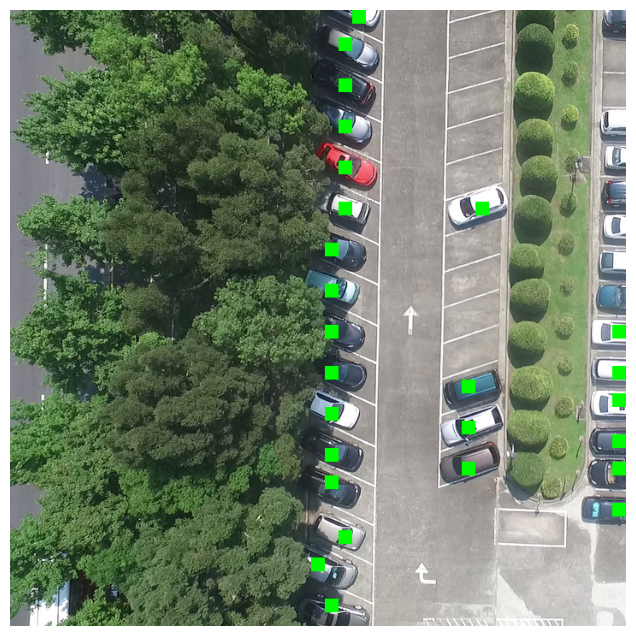

In [220]:
SUBSET = Path("training")
DATA_IDX = 0
CLASS = "car"

class_idx = CLASSES[CLASS]
inspect_dataset = VehicleDataset(
            DATASET_DIR / SUBSET,
            vehicle_data_module._transform,
            vehicle_data_module._target_transform,
)
image, mask, count = inspect_dataset = inspect_dataset[DATA_IDX]
image, mask = convert_from_tensor(image, mask[class_idx])
# mark cells with color on reference image
image[mask == 1] = (0, 255, 0)
# display processed image and mask
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(image)
print(str(count[class_idx]), "object(s) of", CLASS, "class in the picture")

#### Test model results

Predicted 80 from 83 object(s) of car class in the picture


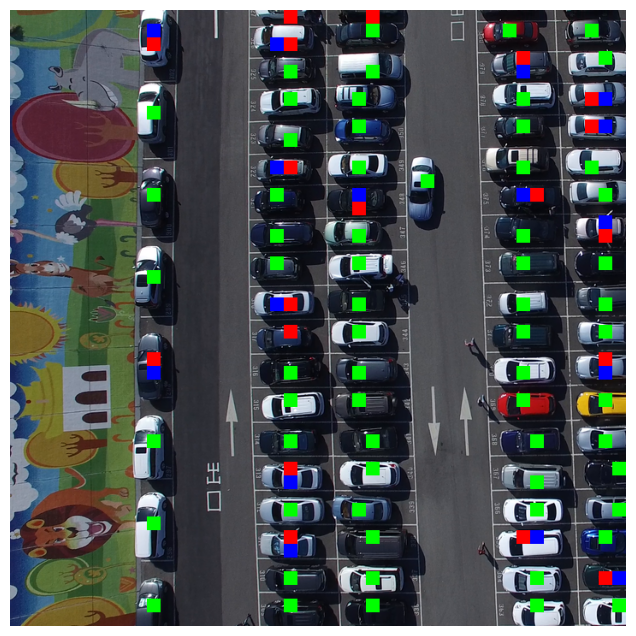

In [221]:
DATA_IDX = 90
CLASS = "car"

# obtain input data from dataset
class_idx = CLASSES[CLASS]
test_dataset = VehicleDataset(
            DATASET_DIR / Path("test" if TEST_DATASET else "validation"),
            vehicle_data_module._transform,
            vehicle_data_module._target_transform,
)
image, mask, count = test_dataset = test_dataset[DATA_IDX]
# evaluate model based on given data
with torch.no_grad():
    FOMO_model.eval()
    mask_pred = FOMO_model(image.unsqueeze(0)).cpu()
    mask_processed, cnt_processed = postprocess_prediction(mask_pred)
mask_processed = mask_processed.squeeze(0)
# mark cells with color on reference image, according to classification case
_, mask = convert_from_tensor(image, mask[class_idx])
image, mask_processed = convert_from_tensor(image, mask_processed[class_idx])
image[mask == 1] = (255, 0, 0)                      # mark as red false negatives
image[mask_processed == 1] = (0, 0, 255)            # mark as blue false positives
mask_check = np.logical_and(mask, mask_processed)
image[mask_check == 1] = (0, 255, 0)                # mark as green true positives
# diplay processed results
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(image)
print("Predicted", str(cnt_processed[class_idx].item()), "from" , str(count[class_idx]), "object(s) of", CLASS, "class in the picture")

#### Export model to ONNX

In [222]:
EXPORT_PATH = Path("Models/fomo.onnx")

FOMO_model.to_onnx(
    str(EXPORT_PATH),
    export_params=True,
    input_names=["image"],
    output_names=["masks"],
    input_sample=torch.randn(1, 3, IMAGE_RESOLUTION, IMAGE_RESOLUTION),
)